# Epidemiology and In-Hospital Mortality of Sepsis Among ICU Admissions: A Retrospective Study Using the MIMIC-III Database
## EHR Activity A3 - Group B
### Authors: Ernest Ceballos, Júlia Galimany, Oriol Galimany


In [ ]:
library(dplyr)
library(tidyr)
library(tibble)
library(lubridate)
library(readr)
library(stringr)
library(data.table)
library(odbc)
library(RMariaDB)
library(DBI)
library(ggplot2)

In [ ]:
con <- dbConnect(
  drv = RMariaDB::MariaDB(),
  username = "ernest.ceballos",
  password = "EeWot5Bu",
  host = "ehr3.deim.urv.cat",
  dbname = "mimiciiiv14",
  port = 3306
)

# PART 1: COHORT 

### Cohort definition
We performed a retrospective observational study using the Medical Information Mart for Intensive Care III (MIMIC-III), version 1.4, a publicly available database containing de-identified health data from over 40,000 adult and neonatal ICU admissions at Beth Israel Deaconess Medical Center between 2001 and 2012. Our cohort comprised all adult patients aged 16 years or older with at least one ICU admission recorded in the ICUSTAYS table. Age was calculated as the difference in years between the ICU admission time (INTIME) and the patient’s date of birth. For patients with multiple ICU stays, each stay was considered an independent observation. Neonatal and pediatric admissions (age < 16 years) were excluded. The final analytical cohort included all qualifying ICU admissions available in the database, without further exclusion criteria.


In [ ]:
# We've build a cohort by joining ICUSTAYS, ADMISSIONS, PATIENTS, and DIAGNOSES_ICD tables
# We've include only adult patients (age >= 16) and extract demographic and clinical variables
cohort_model <- tbl(con, "ICUSTAYS") %>%
  inner_join(tbl(con, "ADMISSIONS"), by = c("HADM_ID" = "HADM_ID", "SUBJECT_ID" = "SUBJECT_ID")) %>%
  inner_join(tbl(con, "PATIENTS"), by = c("SUBJECT_ID" = "SUBJECT_ID")) %>%
  inner_join(tbl(con, "DIAGNOSES_ICD"), by = c("HADM_ID" = "HADM_ID", "SUBJECT_ID" = "SUBJECT_ID")) %>%
  mutate(
    age = year(INTIME) - year(DOB)
  ) %>%
  filter(age >= 16) %>%
  select(
    HADM_ID,
    SUBJECT_ID,
    ICUSTAY_ID,
    age,
    GENDER,
    ETHNICITY,
    INSURANCE,
    ICD9_CODE,
    HOSPITAL_EXPIRE_FLAG
  ) %>%
  collect()

colnames(cohort_model) <- tolower(colnames(cohort_model))
head(cohort_model)

hadm_id,subject_id,icustay_id,age,gender,ethnicity,insurance,icd9_code,hospital_expire_flag
<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>
145834,3,211552,76,M,WHITE,Medicare,0389,0
145834,3,211552,76,M,WHITE,Medicare,78559,0
145834,3,211552,76,M,WHITE,Medicare,5849,0
145834,3,211552,76,M,WHITE,Medicare,4275,0
145834,3,211552,76,M,WHITE,Medicare,41071,0
145834,3,211552,76,M,WHITE,Medicare,4280,0


The final cohort must include an explicit indicator of whether each admission has sepsis or not. This is necessary because the icd9_codes table may contain multiple ICD-9 codes for the same hadm_id, meaning that a single hospital admission can appear multiple times.

To address this, a new binary column called sepsis is created. For each hadm_id, this column is set to 1 if at least one of the associated ICD-9 codes corresponds to sepsis, and 0 otherwise. In this way, each admission is uniquely represented while correctly capturing the presence or absence of sepsis.

In [ ]:
# We've created a binary sepsis indicator based on ICD-9 codes: 038.x (septicemia), 99591 (sepsis), 99592 (severe sepsis), 78552 (septic shock)
cohort_final <- cohort_model %>%
  mutate(sepsis = if_else(
    str_starts(icd9_code, "038") | 
      icd9_code %in% c("99591", "99592", "78552"), 
    1, 0))

In [108]:
head(cohort_final,5)

hadm_id,subject_id,icustay_id,age,gender,ethnicity,insurance,icd9_code,hospital_expire_flag,sepsis
<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>
145834,3,211552,76,M,WHITE,Medicare,0389,0,1
145834,3,211552,76,M,WHITE,Medicare,78559,0,0
145834,3,211552,76,M,WHITE,Medicare,5849,0,0
145834,3,211552,76,M,WHITE,Medicare,4275,0,0
145834,3,211552,76,M,WHITE,Medicare,41071,0,0


In [109]:
dim(cohort_final)

[1] 658810     10

Next, the data are grouped by SUBJECT_ID, HADM_ID, and ICUSTAY_ID. At this stage, each ICUSTAY_ID may still be associated with multiple ICD-9 codes, including several related to sepsis.

To ensure that sepsis codes are retained when present, rows with sepsis = 1 are ordered first within each group. The data are then grouped by SUBJECT_ID, HADM_ID, and ICUSTAY_ID, and only the first row of each group is selected. Because sepsis-positive rows are prioritized at the top, this approach ensures that, whenever sepsis is present for a given ICU stay, the corresponding sepsis ICD-9 code is kept instead of a non-sepsis code.

In [ ]:
# Also we have ensured one row per ICU stay: prioritize sepsis-positive diagnoses when present
cohort_unique <- cohort_final %>%
  group_by(subject_id, hadm_id, icustay_id) %>%
  arrange(desc(sepsis)) %>%
  slice(1) %>%
  ungroup()

In [111]:
dim(cohort_unique)

[1] 53424    10

In [ ]:
# The we have converted the categorical variables to factors 
fact_cols <- c('hadm_id', 'subject_id', 'icustay_id', 'hospital_expire_flag', 'sepsis', 'ethnicity', 'insurance', 'icd9_code')
cohort_unique[fact_cols] = lapply(cohort_unique[fact_cols], as.factor)
head(cohort_unique)

hadm_id,subject_id,icustay_id,age,gender,ethnicity,insurance,icd9_code,hospital_expire_flag,sepsis
<fct>,<fct>,<fct>,<int>,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>
145834,3,211552,76,M,WHITE,Medicare,0389,0,1
185777,4,294638,48,F,WHITE,Private,042,0,0
107064,6,228232,66,F,WHITE,Medicare,40391,0,0
150750,9,220597,41,M,UNKNOWN/NOT SPECIFIED,Medicaid,431,1,0
194540,11,229441,50,F,WHITE,Private,1913,0,0
112213,12,232669,72,M,WHITE,Medicare,1570,1,0


In [113]:
patients_sepsis <- cohort_unique %>%
    filter(sepsis ==1)

head(patients_sepsis)

hadm_id,subject_id,icustay_id,age,gender,ethnicity,insurance,icd9_code,hospital_expire_flag,sepsis
<fct>,<fct>,<fct>,<int>,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>
145834,3,211552,76,M,WHITE,Medicare,0389,0,1
111970,21,216859,88,M,WHITE,Medicare,0388,1,1
176176,33,296681,82,M,UNKNOWN/NOT SPECIFIED,Medicare,0389,0,1
185910,38,248910,76,M,WHITE,Medicare,0389,0,1
189535,61,217135,56,M,WHITE,Private,0389,1,1
116009,62,216609,69,M,PATIENT DECLINED TO ANSWER,Medicare,03849,0,1


In [114]:
#Checking for NA values
anyNA(cohort_unique)
sum(is.na(cohort_unique))
summary(cohort_unique)

[1] TRUE

[1] 14

    hadm_id        subject_id      icustay_id         age        
 163281 :    7   13033  :   41   200001 :    1   Min.   : 16.00  
 186706 :    7   109    :   38   200003 :    1   1st Qu.: 53.00  
 109520 :    6   11861  :   35   200006 :    1   Median : 66.00  
 123178 :    6   5060   :   31   200007 :    1   Mean   : 74.73  
 175448 :    6   19213  :   25   200009 :    1   3rd Qu.: 78.00  
 108976 :    5   20643  :   25   200010 :    1   Max.   :311.00  
 (Other):53387   (Other):53229   (Other):53418                   
    gender                           ethnicity          insurance    
 Length:53424       WHITE                 :37908   Government: 1443  
 Class :character   BLACK/AFRICAN AMERICAN: 4751   Medicaid  : 4734  
 Mode  :character   UNKNOWN/NOT SPECIFIED : 4303   Medicare  :29811  
                    HISPANIC OR LATINO    : 1378   Private   :16854  
                    OTHER                 : 1178   Self Pay  :  582  
                    UNABLE TO OBTAIN      :  846    

In [ ]:
# We've removed 7 rows with missing ICD-9 codes to prevent of NULL values
cohort_unique <- cohort_unique %>% drop_na()

# PART 2: SEPSIS PREVALENCE AND MORTALITY

## Prevalence

In [ ]:
# We've calculated overall sepsis prevalence in ICU admissions
sepsis_prevalence <- cohort_unique %>%
  summarise(
    total_icu_admissions = n(),
    sepsis_icu_admissions = sum(sepsis == "1", na.rm = TRUE),
    sepsis_prevalence = (sepsis_icu_admissions / total_icu_admissions) * 100
  )
sepsis_prevalence

total_icu_admissions,sepsis_icu_admissions,sepsis_prevalence
<int>,<int>,<dbl>
53417,7261,13.59305


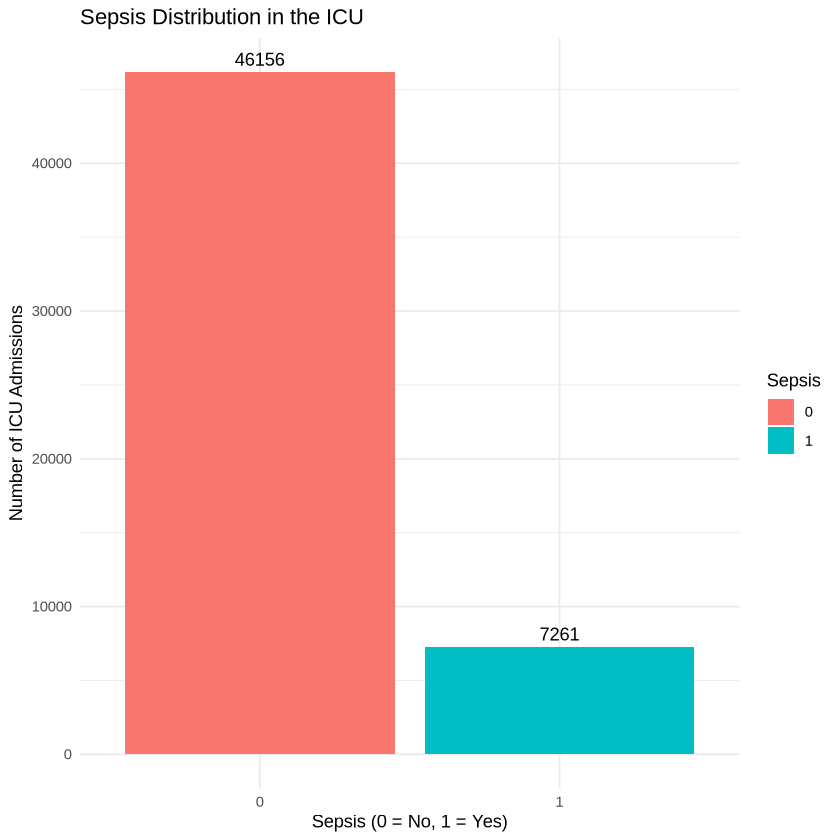

In [ ]:
# This is the visualization of sepsis distribution in the cohort
ggplot(cohort_unique, aes(x = sepsis, fill = sepsis)) +
  geom_bar() +
  geom_text(stat='count', aes(label=after_stat(count)), vjust=-0.5) +
  labs(title = "Sepsis Distribution in the ICU",
       x = "Sepsis (0 = No, 1 = Yes)",
       y = "Number of ICU Admissions",
       fill = "Sepsis") +
  theme_minimal()

### Sepsis prevalence by gender

In [ ]:
# Then we analyze sepsis prevalence stratified by gender
prevalence_gender <- cohort_unique %>%
  group_by(gender) %>%
  summarise(
    total_admissions = n(),
    sepsis_cases = sum(sepsis == "1"),
    non_sepsis_cases = sum(sepsis == "0"),
    prevalence_percent = (sepsis_cases / total_admissions) * 100
  )
prevalence_gender

gender,total_admissions,sepsis_cases,non_sepsis_cases,prevalence_percent
<chr>,<int>,<int>,<int>,<dbl>
F,23323,3179,20144,13.63032
M,30094,4082,26012,13.56417


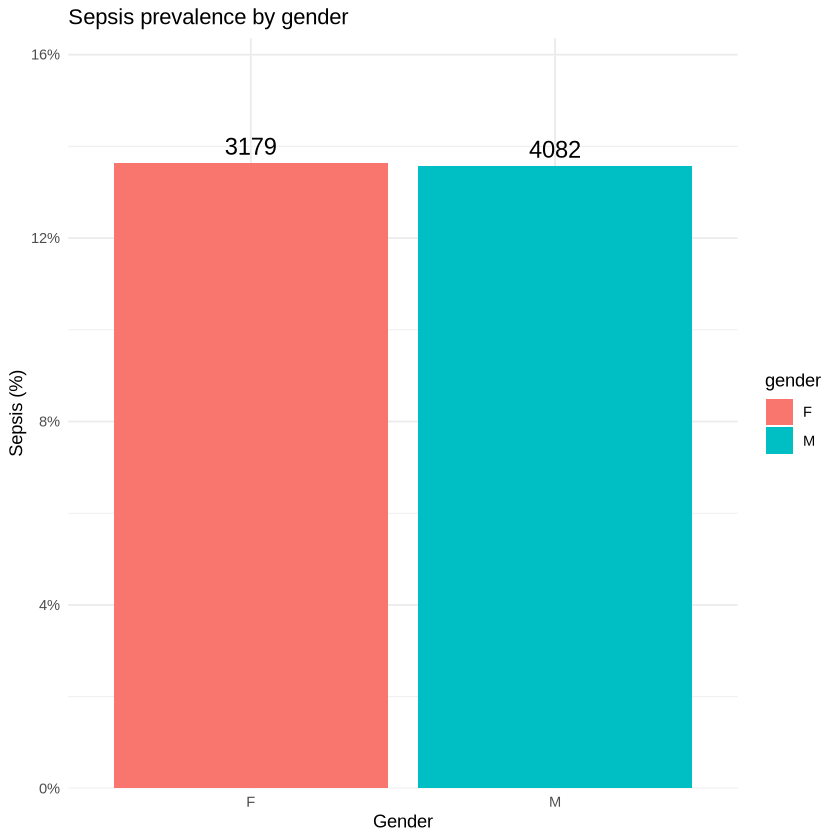

In [ ]:
# And we plotted this distribution
ggplot(prevalence_gender, aes(x = gender, y = prevalence_percent, fill = gender)) +
  geom_col() +
  geom_text(aes(label = sepsis_cases), 
            vjust = -0.5,
            size = 5) +
  scale_y_continuous(labels = function(x) paste0(x, "%"),
                     expand = expansion(mult = c(0, 0.2))) +
  labs(title = "Sepsis prevalence by gender",
       y = "Sepsis (%)",
       x = "Gender") +
  theme_minimal()

### Sepsis prevalence by age

In [ ]:
# We analyze sepsis prevalence by age group (16-40, 40-60, 60-80, 80+)
prevalence_age <- cohort_unique %>%
  mutate(age_group = cut(age, 
                         breaks = c(16, 40, 60, 80, Inf), 
                         labels = c("16-40", "40-60", "60-80", "80+"),
                         right = FALSE)) %>%
  group_by(age_group) %>%
  summarise(
    total_admissions = n(),
    sepsis_cases = sum(sepsis == "1"),
    prevalence_prop = sepsis_cases / total_admissions
  ) %>%
  filter(!is.na(age_group))
prevalence_age

age_group,total_admissions,sepsis_cases,prevalence_prop
<fct>,<int>,<int>,<dbl>
16-40,5118,428,0.08362642
40-60,14678,1862,0.12685652
60-80,22252,3155,0.14178501
80+,11369,1816,0.15973261


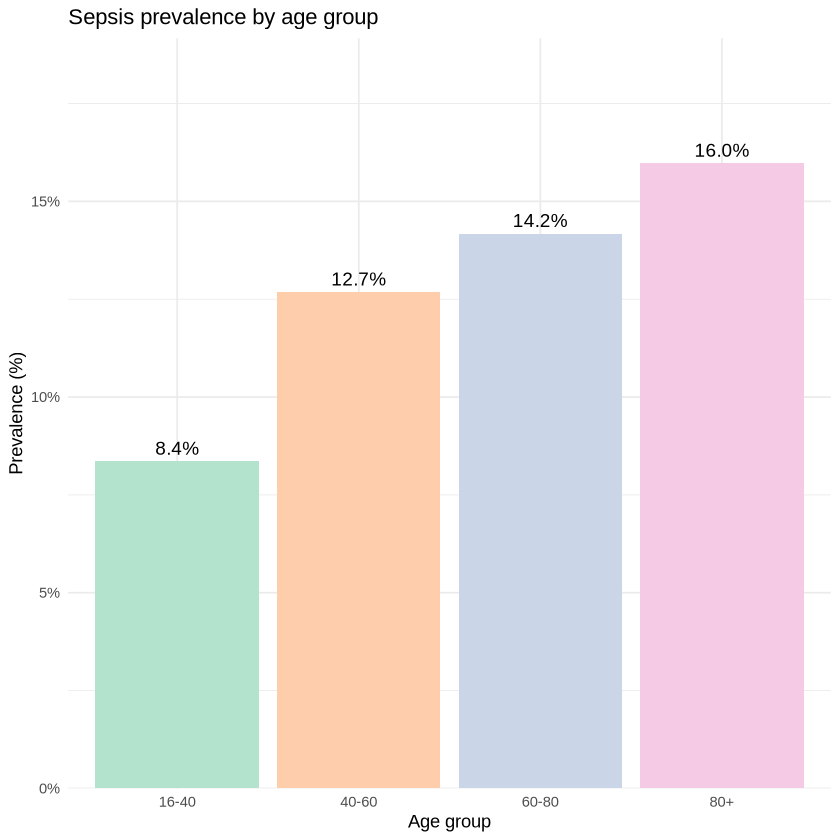

In [ ]:
# We plot it
ggplot(prevalence_age, aes(x = age_group, y = prevalence_prop, fill = age_group)) +
  geom_col() +
  geom_text(aes(label = scales::percent(prevalence_prop, accuracy = 0.1)), 
            vjust = -0.5, size = 4) +
  scale_y_continuous(labels = scales::percent, 
                     expand = expansion(mult = c(0, 0.2))) +
  scale_fill_brewer(palette = "Pastel2") +
  labs(title = "Sepsis prevalence by age group",
       x = "Age group",
       y = "Prevalence (%)") +
  theme_minimal() +
  theme(legend.position = "none")

## Mortality

Sepsis mortality rate: 32.57 %


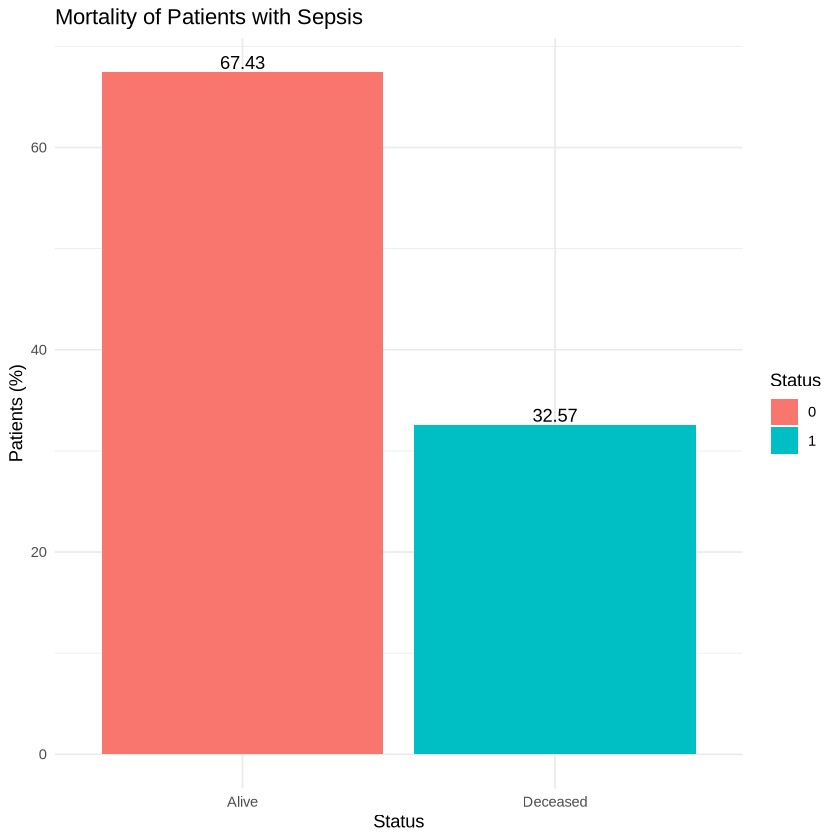

In [ ]:
# We calculate and visualize mortality rate for patients WITH sepsis
df_sepsis <- cohort_unique %>%
  filter(sepsis == 1) %>%
  select(hospital_expire_flag) %>%
  group_by(hospital_expire_flag) %>%
  summarise(count = n()) %>%
  mutate(Percentage_Status = count / sum(count) * 100)

mortality_sepsis <- df_sepsis %>%
  filter(hospital_expire_flag == 1) %>%
  pull(Percentage_Status)
cat("Sepsis mortality rate:", round(mortality_sepsis, 2), "%\n")

ggplot(df_sepsis,
       aes(x = factor(hospital_expire_flag, levels = c(0, 1), labels = c('Alive', 'Deceased')),
           y = Percentage_Status, 
           fill = hospital_expire_flag, 
           label = round(Percentage_Status, 2))) +
  geom_col() +
  geom_text(position = position_dodge(0.5), vjust = -0.25) +
  labs(x = 'Status', y = 'Patients (%)', 
       title = 'Mortality of Patients with Sepsis', fill = 'Status') + 
  theme_minimal()

Mortality rate without sepsis: 9.05 %


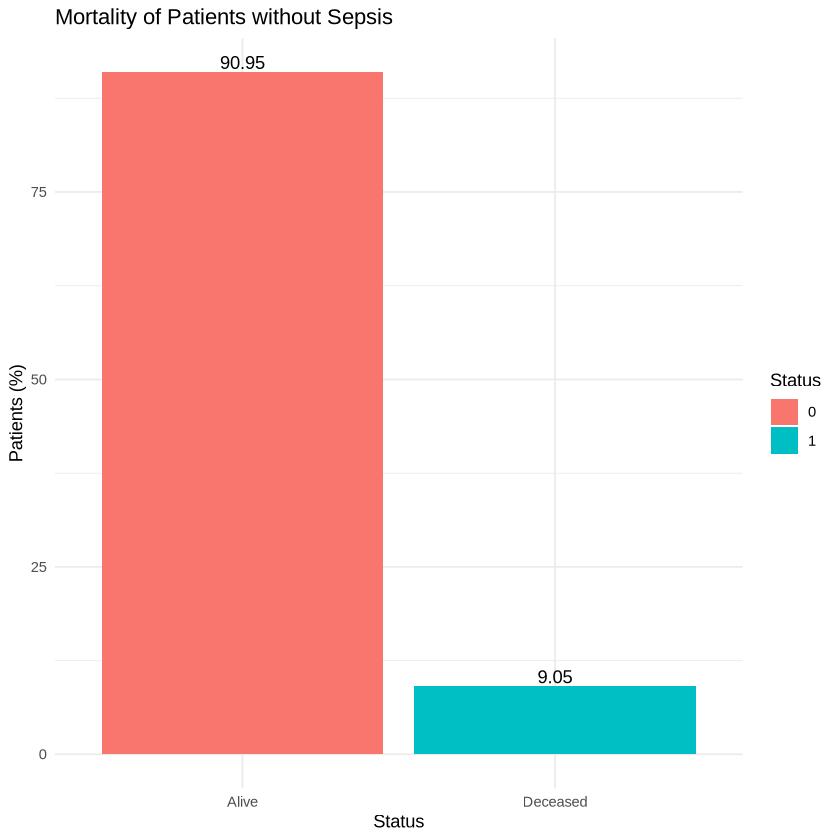

In [ ]:
# Also we calculate and visualize mortality rate for patients WITHOUT sepsis
df_nosepsis <- cohort_unique %>%
  filter(sepsis == 0) %>%
  select(hospital_expire_flag) %>%
  group_by(hospital_expire_flag) %>%
  summarise(count = n()) %>%
  mutate(Percentage_Status = count / sum(count) * 100)

mortality_nosepsis <- df_nosepsis %>%
  filter(hospital_expire_flag == 1) %>%
  pull(Percentage_Status)
cat("Mortality rate without sepsis:", round(mortality_nosepsis, 2), "%\n")

ggplot(df_nosepsis,
       aes(x = factor(hospital_expire_flag, levels = c(0, 1), labels = c('Alive', 'Deceased')),
           y = Percentage_Status, 
           fill = hospital_expire_flag, 
           label = round(Percentage_Status, 2))) +
  geom_col() +
  geom_text(position = position_dodge(0.5), vjust = -0.25) +
  labs(x = 'Status', y = 'Patients (%)', 
       title = 'Mortality of Patients without Sepsis', fill = 'Status') + 
  theme_minimal()

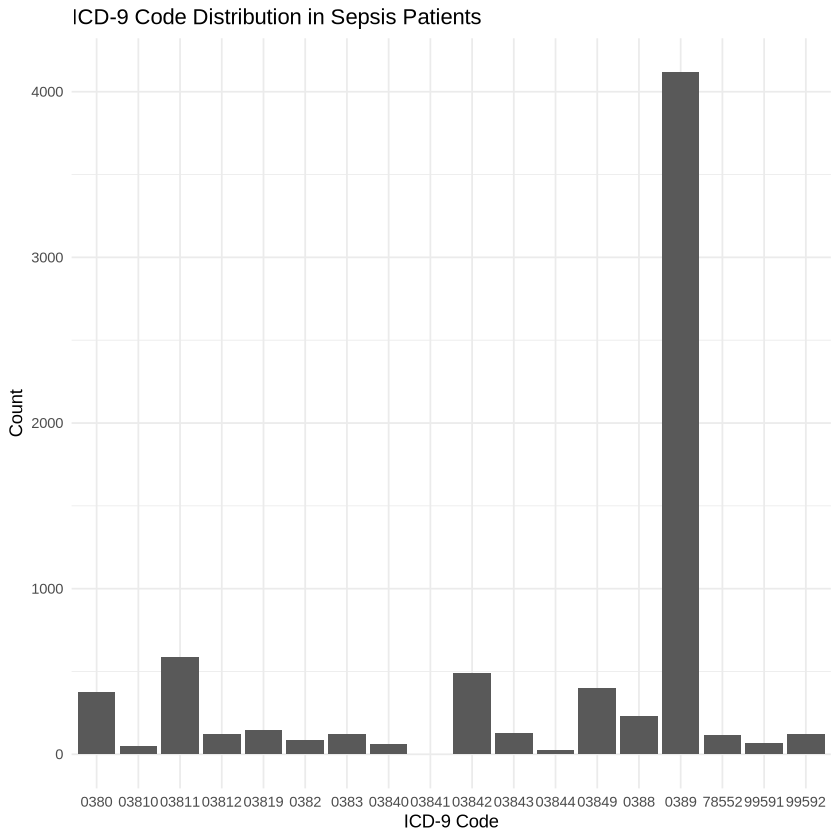

In [ ]:
# We also have explored ICD-9 code distribution among sepsis patients
ggplot(patients_sepsis, aes(x = icd9_code)) + 
  geom_bar() +
  labs(title = "ICD-9 Code Distribution in Sepsis Patients", x = "ICD-9 Code", y = "Count") +
  theme_minimal()

# PART 3: LOGISTIC REGRESSION

We build a logistic regression model to evaluate whether mortality among ICU patients with sepsis can be predicted using the following predictor variables: age, gender, ethnicity, insurance, and ICD-9 code. The outcome variable is hospital_expire_flag, which indicates whether the patient died during the hospital stay.

In [125]:
#install.packages("caTools")

In [126]:
library(caTools)

In [ ]:
# We've split data into training (90%) and testing (10%) sets
# Using set.seed for reproducibility
set.seed(100)
spl = sample.split(patients_sepsis$hospital_expire_flag, SplitRatio = 0.9)
train = subset(patients_sepsis, spl == TRUE)
test = subset(patients_sepsis, spl == FALSE)

In [ ]:
# We fit the logistic regression model: mortality ~ demographic + clinical predictors
logistic <- glm(hospital_expire_flag ~ age + gender + ethnicity + insurance + icd9_code, 
                data = train, family = 'binomial')
summary(logistic)


Call:
glm(formula = hospital_expire_flag ~ age + gender + ethnicity + 
    insurance + icd9_code, family = "binomial", data = train)

Coefficients:
                                                                    Estimate
(Intercept)                                                       -7.720e-01
age                                                                1.233e-03
genderM                                                            2.256e-02
ethnicityAMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE  1.405e+01
ethnicityASIAN                                                    -1.078e+00
ethnicityASIAN - ASIAN INDIAN                                     -1.773e+00
ethnicityASIAN - CAMBODIAN                                        -1.683e+00
ethnicityASIAN - CHINESE                                          -3.669e-01
ethnicityASIAN - FILIPINO                                          1.430e+01
ethnicityASIAN - KOREAN                                           -2.088e-01
ethn

In [ ]:
# We'have generated predicted probabilities on the test set
predict_test <- predict(logistic, type = "response", newdata = test)
head(predict_test)

1         2         3         4         5         6 
0.3687688 0.4856561 0.2876763 0.3368956 0.3615382 0.2922448

In [ ]:

library(pROC)

In [131]:
# Calculate ROC curve and AUC for model evaluation
roc_curve <- roc(response = test$hospital_expire_flag, predictor = predict_test)
auc_value <- auc(roc_curve)
cat('AUC:', round(auc_value, 3))

Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUC: 0.622

Warning message in geom_segment(aes(x = 0, xend = 1, y = 0, yend = 1), color = "darkgrey", :
“All aesthetics have length 1, but the data has 565 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”


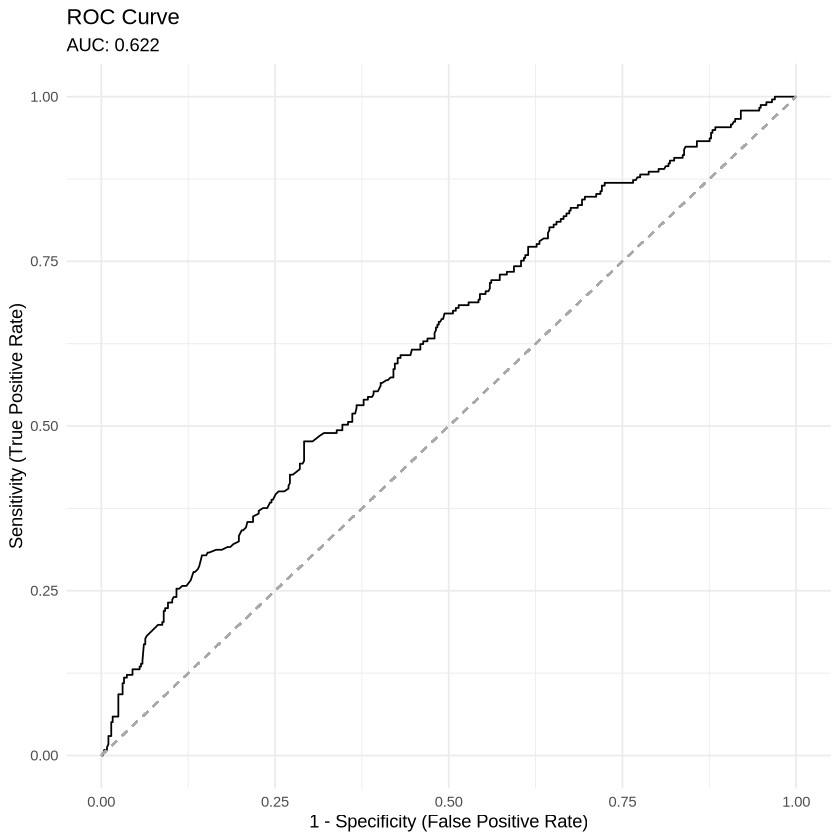

In [ ]:
# Then we do a plotting ROC curve with AUC value displayed
ggroc(data = roc_curve, legacy.axes = TRUE) +
  geom_segment(aes(x = 0, xend = 1, y = 0, yend = 1), 
               color = "darkgrey", linetype = "dashed") +
  theme_minimal() + 
  labs(title = "ROC Curve", 
       subtitle = paste0("AUC: ", round(auc_value, 3)),
       x = "1 - Specificity (False Positive Rate)", 
       y = "Sensitivity (True Positive Rate)")

In [ ]:
# we find optimal classification threshold using closest-to-top-left method
coords <- coords(roc_curve, "best", best.method = "closest.topleft")
best_threshold <- coords$threshold
cat("Optimal threshold:", round(best_threshold, 3))

Optimal threshold: 0.334

In [ ]:
# and we reate confusion matrix and calculate accuracy
predicted_class <- ifelse(predict_test >= best_threshold, 1, 0)
confusion_matrix <- table(test$hospital_expire_flag, predicted_class)
accuracy <- sum(diag(confusion_matrix)) / sum(confusion_matrix)
confusion_matrix
cat("Accuracy:", round(accuracy, 3))

   predicted_class
      0   1
  0 281 209
  1  94 143

Accuracy: 0.583

In [ ]:
# We do calculate performance metrics from confusion matrix
TN <- confusion_matrix[1, 1]  
FP <- confusion_matrix[1, 2]  
FN <- confusion_matrix[2, 1]  
TP <- confusion_matrix[2, 2]  

Sensitivity <- TP / (TP + FN)  
Specificity <- TN / (TN + FP)  
PPV <- TP / (TP + FP)          
NPV <- TN / (TN + FN)          

cat("Sensitivity:", round(Sensitivity, 3), "\n")
cat("Specificity:", round(Specificity, 3), "\n")
cat("PPV (Precision):", round(PPV, 3), "\n")
cat("NPV:", round(NPV, 3))

Sensitivity: 0.603 
Specificity: 0.573 
PPV (Precision): 0.406 
NPV: 0.749

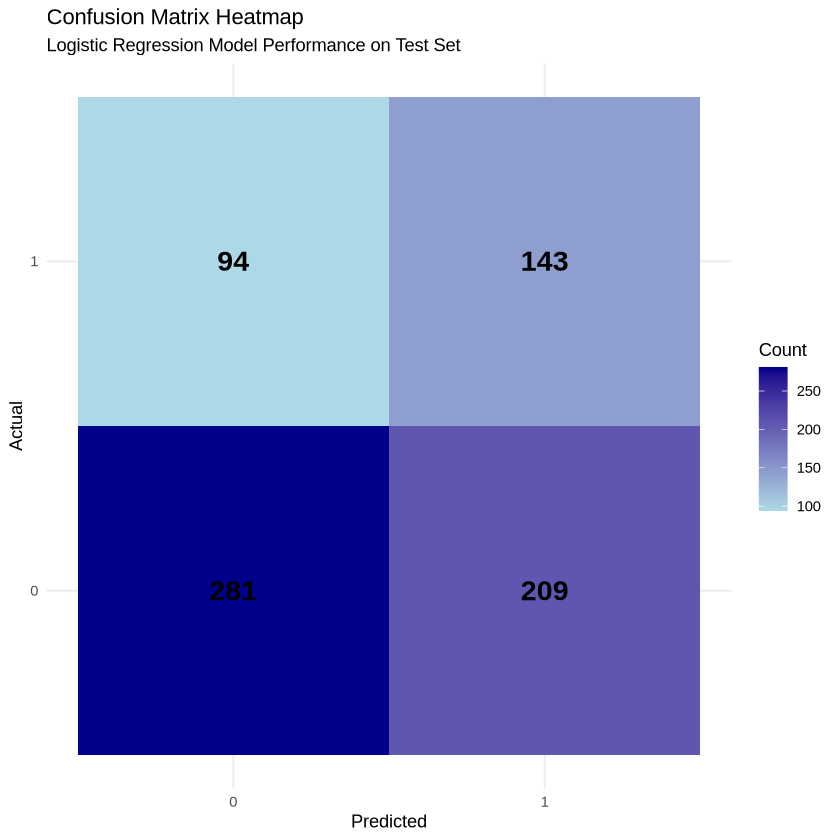

In [ ]:
# We create and visualize confusion matrix as a heatmap
library(reshape2)

# We create a heatmap of the confusion matrix
confusion_df <- as.data.frame(confusion_matrix)
colnames(confusion_df) <- c("Actual", "Predicted", "Count")

ggplot(confusion_df, aes(x = Predicted, y = Actual, fill = Count)) +
  geom_tile() +
  geom_text(aes(label = Count), size = 6, fontface = "bold") +
  scale_fill_gradient(low = "lightblue", high = "darkblue") +
  labs(title = "Confusion Matrix Heatmap",
       subtitle = "Logistic Regression Model Performance on Test Set",
       x = "Predicted", y = "Actual") +
  theme_minimal()


## VIF
Variance Inflation Factors (VIF) measure the degree to which multicollinearity inflates the variance of regression coefficients, with values indicating how much a predictor's coefficient variance is increased due to correlation with other predictors. VIF was calculated using manual auxiliary linear regressions (VIF $= 1/(1-R^2)$) rather than the standard \texttt{car} package, as the package was unavailable in the computational environment. VIF values below 5 indicate no concern, values between 5--10 suggest moderate multicollinearity, and values above 10 indicate severe multicollinearity.

In [ ]:

# The  VIF formula is (VIF = 1 / (1 - R²) where R² is from auxiliary regression)

vif_manual <- function(model_object) {
  X <- model.matrix(model_object)
  X <- X[, -1]
  col_names <- colnames(X)
  vif_values <- numeric(ncol(X))
  
  for (i in 1:ncol(X)) {
    # We escape column names with backticks for formula
    response_var <- paste0("`", col_names[i], "`")
    predictor_vars <- paste0("`", col_names[-i], "`", collapse=" + ")
    aux_formula <- as.formula(paste(response_var, "~", predictor_vars))
    aux_model <- lm(aux_formula, data=as.data.frame(X))
    
    # The R-squared
    r_squared <- summary(aux_model)$r.squared
    
    # And calculate VIF
    vif_values[i] <- 1 / (1 - r_squared)
  }
  vif_results <- data.frame(
    Predictor = col_names,
    VIF = vif_values
  )
  
  return(vif_results)
}

# Calculate VIF
vif_results <- vif_manual(logistic)

cat("Variance Inflation Factors (VIF) for All Predictors:\n")
cat("================================================\n")
print(vif_results)
cat("\n")



vif_results_agg <- vif_results %>%
  mutate(
    main_predictor = case_when(
      Predictor == "age" ~ "age",
      Predictor == "genderM" ~ "gender",
      str_detect(Predictor, "^ethnicity") ~ "ethnicity",
      str_detect(Predictor, "^insurance") ~ "insurance",
      str_detect(Predictor, "^icd9_code") ~ "icd9_code",
      TRUE ~ Predictor
    )
  ) %>%
  group_by(main_predictor) %>%
  summarise(VIF_avg = mean(VIF), .groups = "drop") %>%
  rename(Predictor = main_predictor, VIF = VIF_avg)

cat("\nAggregated VIF by Main Predictor:\n")
cat("================================================\n")
print(vif_results_agg)
cat("\n")

high_vif <- vif_results_agg[vif_results_agg$VIF > 5, ]
if(nrow(high_vif) > 0) {
  cat("Predictors with VIF > 5 (potential multicollinearity):\n")
  print(high_vif)
} else {
  cat("No predictors with VIF > 5. No multicollinearity concern.\n")
}


Variance Inflation Factors (VIF) for All Predictors:
(Manual calculation - all 5 main predictors)
                                                           Predictor        VIF
1                                                                age   1.127006
2                                                            genderM   1.035102
3  ethnicityAMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE   1.502958
4                                                     ethnicityASIAN  59.930043
5                                      ethnicityASIAN - ASIAN INDIAN  12.065244
6                                         ethnicityASIAN - CAMBODIAN   4.020201
7                                           ethnicityASIAN - CHINESE  19.534215
8                                          ethnicityASIAN - FILIPINO   1.505342
9                                            ethnicityASIAN - KOREAN   2.010339
10                                            ethnicityASIAN - OTHER   1.505480
11                    

### Model Premises

**Limitation - Independence of Observations:** We acknowledge that the same patient (subject_id) may contribute multiple hospital admissions (hadm_id), and the same admission may include multiple ICU stays (icustay_id). This potential correlation between observations from the same patient represents a limitation of our analysis, as standard logistic regression assumes independence.